In [1]:
import numpy as np
import pandas as pd
from evaluation import evaluate_global_shap_scores
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

import warnings
import logging
warnings.filterwarnings("ignore")
logging.getLogger("numba").setLevel(logging.WARNING)
logging.getLogger("shap").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)


In [30]:
base_dir = '../../'
data_path = base_dir + 'dataset/IBS_species/' + 'PRJNA579180_genus_pivoted.csv'
result_dir = base_dir + 'result/R/'

df = pd.read_csv(data_path)
df = df.drop(columns="acc")

### Use All Features (Accuracy = 72%)

In [31]:
X = df.drop(columns=['class'])
y = df['class']

param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)
model = random_search.best_estimator_
best_params = random_search.best_params_
print(best_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


In [32]:
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

1.0


### Use top 30 Features (Accuracy = 76%)

In [30]:
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_  
})
top_30_features = importances.nlargest(30, 'importance')['feature'].values
print(top_30_features)

['Escherichia virus phiX174' 'Prevotella histicola'
 'Prevotella melaninogenica' 'Prevotella salivae'
 'Enterobacteria phage phiX174 sensu lato' 'Muribaculum intestinale'
 'Hungatella hathewayi' 'Prevotella copri' 'Parabacteroides goldsteinii'
 'Anaerotruncus colihominis' 'Blautia hydrogenotrophica'
 'Melioribacter roseus' 'Fluviimonas pallidilutea' 'Cecembia lonarensis'
 'Prevotella albensis' 'Phocaeicola abscessus'
 'Ruthenibacterium lactatiformans' 'Ruminococcus flavefaciens'
 'Bacteroides stercoris' '[Clostridium] viride' 'Dorea formicigenerans'
 'Porphyromonas pasteri' 'Marvinbryantia formatexigens'
 'Enterocloster aldenensis' 'Acetobacteroides hydrogenigenes'
 'Blautia obeum' 'Blautia wexlerae' 'Blautia faecis' 'Niabella aurantiaca'
 'Dyadobacter hamtensis']


In [33]:
top_30_features = ['Collinsella', 'Bacteroides' ,'Ruthenibacterium', 'Lactobacillus',
                   'Faecalibacterium', 'Prevotella', 'Akkermansia', 'Oscillibacter',
                   'Anaerotruncus' ,'Odoribacter', 'Lachnoclostridium', 'Butyricimonas',
                   'Porphyromonas' ,'Hungatella' ,'Flavonifractor', 'Alistipes',
                   'Parabacteroides', 'Anaerobutyricum' ,'Dorea', 'Bifidobacterium',
                   'Fusicatenibacter', 'Leptotrichia', 'Gemella', 'Intestinimonas',
                   'Fusobacterium', 'Coprococcus' ,'Tyzzerella', 'Eisenbergiella',
                   'Anaerostipes', 'Paraprevotella']
X = X[top_30_features]

y = df['class']

param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)
model = random_search.best_estimator_
best_params = random_search.best_params_
print(best_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}


In [34]:
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

1.0


### Generate .csv for PC+IDA

In [35]:
predicted_probabilities = model.predict_proba(X)
prob_df = pd.DataFrame(predicted_probabilities, columns=[f'Prob_Class_{i}' for i in range(predicted_probabilities.shape[1])])
prob_df = prob_df.rename(columns={'Prob_Class_1': 'IBS'})
result_df = pd.concat([X.reset_index(drop=True), prob_df.reset_index(drop=True)], axis=1)
result_df.to_excel('../../dataset/IBS_species/Predicted_Probabilites_PRJNA579180_genus_pivoted.xlsx', index=False)

### Causal SHAP Top Features

In [31]:
X_train['Prob_Class_1'] = model.predict_proba(X_train)[:,1]

In [32]:
from fast_causal_inference import FastCausalInference

ci = FastCausalInference(data=X_train, model=model, target_variable='Prob_Class_1')
ci.load_causal_strengths(result_dir + 'Mean_Causal_Effect_IBS_Species_PRJNA812699_family_pivoted.json')
x_instance = X_train.iloc[33]

print(ci.compute_modified_shap_proba(x_instance, is_classifier=True))

Removed 2 edges to make the graph acyclic:
  Clostridiaceae -> Oscillospiraceae (weight: 0.18039553)
  Prevotellaceae -> Veillonellaceae (weight: 0.16622609)
{'Microviridae': np.float64(0.0011505683526237505), 'Lachnospiraceae': np.float64(0.006486655891813884), 'Dysgonomonadaceae': np.float64(-0.00222987749646558), 'Spirosomaceae': np.float64(0.008104952985457213), 'Prevotellaceae': np.float64(0.02635448276317736), 'Bacteroidaceae': np.float64(0.00798660773018692), 'Muribaculaceae': np.float64(0.00039211455354923064), 'Melioribacteraceae': np.float64(0.041477231252633535), 'Clostridiaceae': np.float64(0.0011531386312022408), 'Oscillospiraceae': np.float64(0.005756286418282221), 'Bifidobacteriaceae': np.float64(-0.00011872790509169052), 'Eubacteriales Family XIII. Incertae Sedis': np.float64(0.0016262478154029578), 'Veillonellaceae': np.float64(0.00021296532896585414), 'Marinilabiliaceae': np.float64(0.0010861579680051144), 'Akkermansiaceae': np.float64(0.00026428718365290277), 'Peptos

In [ ]:
from tqdm import tqdm

phi = []
for i in tqdm(range(len(X_test)), desc="Computing SHAP values", unit="sample"):
    phi.append(ci.compute_modified_shap_proba(X_test.iloc[i], is_classifier=True))

phi_df = pd.DataFrame(phi)
mean_values = phi_df.abs().mean()
global_importance = mean_values.sort_values(ascending=False)

In [ ]:
from visualization import plot_importance_table

plot_importance_table(global_importance, top_n=6, figsize=(8, 4))

## Join

In [31]:
base_dir = '../../'
species_path = base_dir + 'dataset/IBS_species/' + 'PRJNA812699_species_pivoted.csv'
metadata_path = base_dir + 'dataset/IBS_species/' + 'PRJNA812699_metadata.csv'
data_path = base_dir + 'dataset/' + 'Real_World_IBS.xlsx'
result_dir = base_dir + 'result/R/'

species_df = pd.read_csv(species_path)
metadata_df = pd.read_csv(metadata_path)
metabolite_df = pd.read_excel(data_path)

In [32]:
step1_df = pd.merge(metabolite_df, metadata_df, left_on='Patient', right_on='host_subject_id', how='inner')
final_df = pd.merge(step1_df, species_df, left_on='Run', right_on='acc',how='inner')

In [33]:
final_df = final_df[['Group', 'Escherichia virus phiX174', 'Prevotella histicola',
 'Prevotella melaninogenica', 'Prevotella salivae',
 'Enterobacteria phage phiX174 sensu lato' ,'Muribaculum intestinale',
 'Hungatella hathewayi', 'Prevotella copri', 'Parabacteroides goldsteinii',
 'Anaerotruncus colihominis', 'Blautia hydrogenotrophica',
 'Melioribacter roseus', 'Fluviimonas pallidilutea' ,'Cecembia lonarensis',
 'Prevotella albensis', 'Phocaeicola abscessus',
 'Ruthenibacterium lactatiformans', 'Ruminococcus flavefaciens',
 'Bacteroides stercoris', '[Clostridium] viride', 'Dorea formicigenerans',
 'Porphyromonas pasteri', 'Marvinbryantia formatexigens',
 'Enterocloster aldenensis', 'Acetobacteroides hydrogenigenes',
 'Blautia obeum' ,'Blautia wexlerae' ,'Blautia faecis' ,'Niabella aurantiaca',
 'Dyadobacter hamtensis', 'xylose', 'xanthosine', 'valylglutamine', 'valine betaine', 'ursodeoxycholate sulfate (1)', 'uracil', 'tyrosine', 'tryptophylglycine', "trigonelline (N'-methylnicotinate)", 'tricarballylate', 'thymine', 'threonine', 'thiamin (Vitamin B1)', 'theobromine', 'syringic acid', 'succinimide', 'succinate', 'stearate (18:0)', 'stachydrine', 'sphingosine', 'serotonin', 'serine', 'salicylate', 'saccharin', 'ribulose/xylulose', 'riboflavin (Vitamin B2)', 'ribitol', 'quinolinate', 'quinate', 'pyroglutamine*']]

In [34]:
final_df = final_df.drop_duplicates()
X = final_df.drop(columns='Group')
Y = final_df['Group']

In [35]:
print(X.shape)

(781, 60)


In [36]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
estimator=rf, param_distributions=param_dist, n_iter=50,
        cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)
model = random_search.best_estimator_
best_params = random_search.best_params_
print("Model trained successfully.")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Model trained successfully.


In [37]:
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.910828025477707


In [38]:
predicted_probabilities = model.predict_proba(X)
prob_df = pd.DataFrame(predicted_probabilities, columns=[f'Prob_Class_{i}' for i in range(predicted_probabilities.shape[1])])
result_df = pd.concat([X.reset_index(drop=True), prob_df.reset_index(drop=True)], axis=1)
result_df.to_excel('../../dataset/IBS_species/PRJNA812699_IBS_Species_Metabolites_Probabilities.xlsx', index=False)


In [41]:
from fast_causal_inference import FastCausalInference

predicted_probabilities = model.predict_proba(X_train)[:,1]
X_train['Prob_Class_1'] = predicted_probabilities
ci = FastCausalInference(data=X_train, model=model, target_variable='Prob_Class_1')
ci.load_causal_strengths(result_dir + 'Mean_Causal_Effect_IBS_Species_PRJNA812699_species_metabolites_pivoted.json')
x_instance = X_train.iloc[33]

print(ci.compute_modified_shap_proba(x_instance, is_classifier=True))

Removed 2 edges to make the graph acyclic:
  Enterobacteria phage phiX174 sensu lato -> Escherichia virus phiX174 (weight: 0.7203521)
  Blautia obeum -> Blautia wexlerae (weight: 0.1932989)
{'Escherichia virus phiX174': np.float64(0.13041992987465412), 'Prevotella histicola': np.float64(-0.0), 'Prevotella melaninogenica': np.float64(-0.0), 'Prevotella salivae': np.float64(-0.0), 'Enterobacteria phage phiX174 sensu lato': np.float64(-0.0), 'Muribaculum intestinale': np.float64(-0.007739588142385134), 'Hungatella hathewayi': np.float64(-0.002974884082012697), 'Prevotella copri': np.float64(0.00023657001594467328), 'Parabacteroides goldsteinii': np.float64(-0.00316452909481164), 'Anaerotruncus colihominis': np.float64(-0.0017079402487761596), 'Blautia hydrogenotrophica': np.float64(-0.0027753881226692052), 'Melioribacter roseus': np.float64(-0.00018419949837453095), 'Fluviimonas pallidilutea': np.float64(-0.009615612727522331), 'Cecembia lonarensis': np.float64(-0.0), 'Prevotella albensis

In [42]:
from tqdm import tqdm

phi = []
for i in tqdm(range(len(X_test)), desc="Computing SHAP values", unit="sample"):
    phi.append(ci.compute_modified_shap_proba(X_test.iloc[i], is_classifier=True))

phi_df = pd.DataFrame(phi)
mean_values = phi_df.abs().mean()
global_importance = mean_values.sort_values(ascending=False)

Computing SHAP values: 100%|██████████| 157/157 [49:37<00:00, 18.96s/sample] 


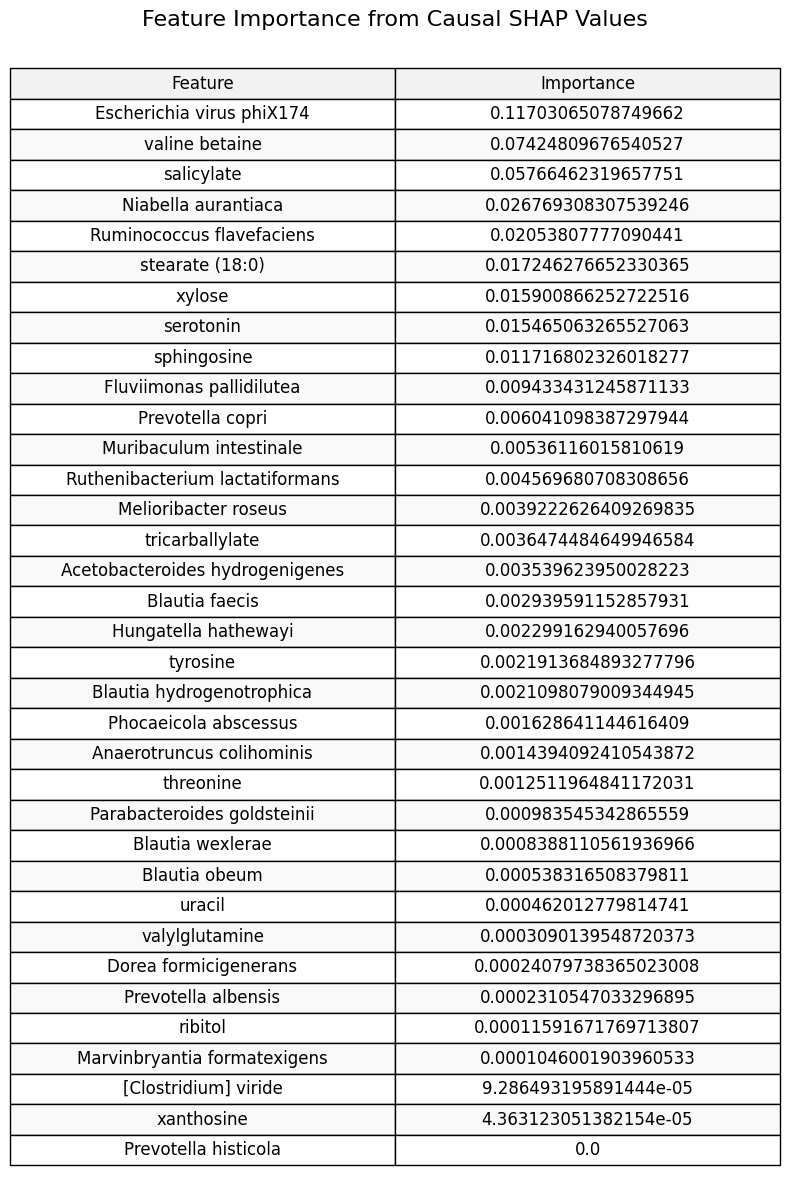

(<Figure size 800x1200 with 1 Axes>,
 <Axes: title={'center': 'Feature Importance from Causal SHAP Values'}>)

In [43]:
from visualization import plot_importance_table

plot_importance_table(global_importance, top_n=35, figsize=(8, 12))

Removed 2 edges to make the graph acyclic:
  Enterobacteria phage phiX174 sensu lato -> Escherichia virus phiX174 (weight: 0.7203521)
  Blautia obeum -> Blautia wexlerae (weight: 0.1932989)
{'Escherichia virus phiX174': np.float64(-0.06393665010566907), 'Prevotella histicola': np.float64(-0.0), 'Prevotella melaninogenica': np.float64(-0.0), 'Prevotella salivae': np.float64(-0.0), 'Enterobacteria phage phiX174 sensu lato': np.float64(-0.0), 'Muribaculum intestinale': np.float64(-0.006975509304912399), 'Hungatella hathewayi': np.float64(-0.002445020357795154), 'Prevotella copri': np.float64(-0.0009533779461730325), 'Parabacteroides goldsteinii': np.float64(-0.0023529532623324497), 'Anaerotruncus colihominis': np.float64(-0.0020476983400453657), 'Blautia hydrogenotrophica': np.float64(-0.001013850923711644), 'Melioribacter roseus': np.float64(-0.004931199561443611), 'Fluviimonas pallidilutea': np.float64(-0.023085581549873082), 'Cecembia lonarensis': np.float64(-0.0), 'Prevotella albensis

Computing SHAP values: 100%|██████████| 157/157 [49:28<00:00, 18.91s/sample]


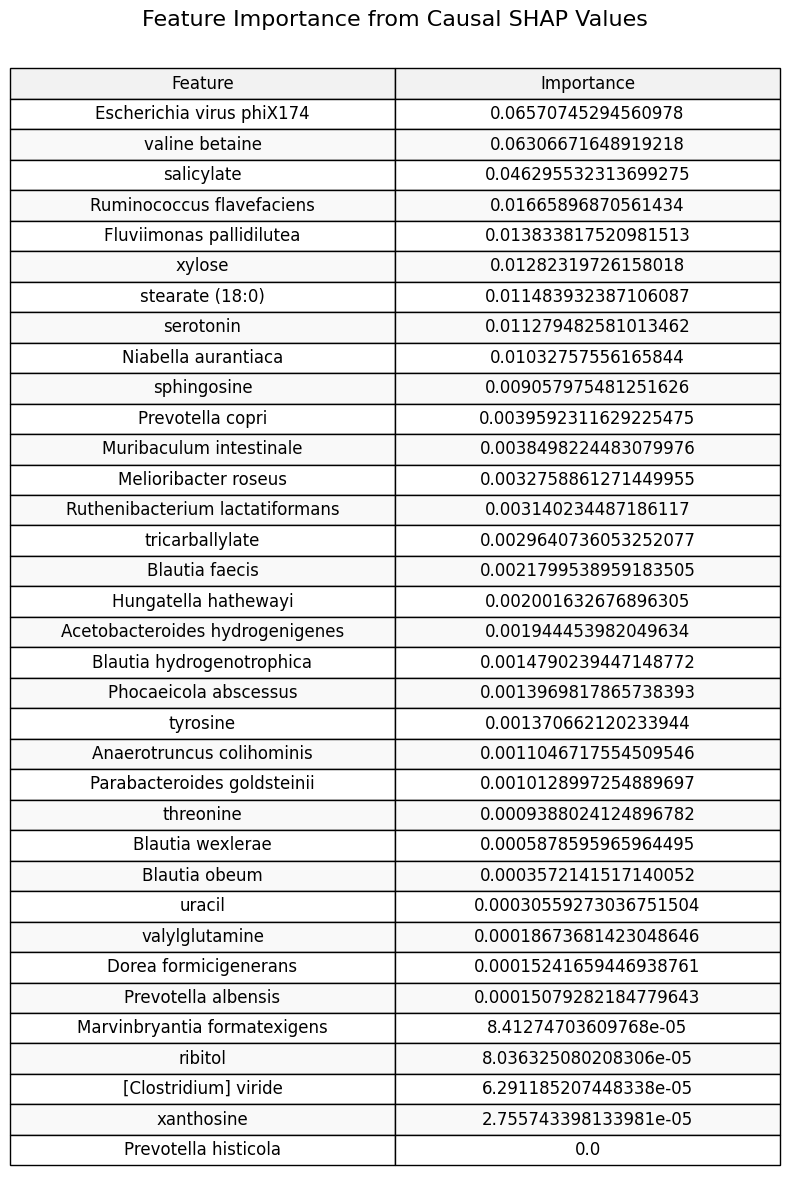

(<Figure size 800x1200 with 1 Axes>,
 <Axes: title={'center': 'Feature Importance from Causal SHAP Values'}>)

In [46]:
from visualization import plot_importance_table
from tqdm import tqdm
from fast_causal_inference import FastCausalInference

X_train['Prob_Class_1'] = predicted_probabilities
ci = FastCausalInference(data=X_train, model=model, target_variable='Prob_Class_1')
ci.load_causal_strengths(result_dir + 'Mean_Causal_Effect_IBS_Species_PRJNA812699_species_metabolites_pivoted.json')
x_instance = X_train.iloc[33]

print(ci.compute_modified_shap_proba(x_instance, is_classifier=True))

phi = []
for i in tqdm(range(len(X_test)), desc="Computing SHAP values", unit="sample"):
    phi.append(ci.compute_modified_shap_proba(X_test.iloc[i], is_classifier=True))

phi_df = pd.DataFrame(phi)
mean_values = phi_df.abs().mean()
global_importance = mean_values.sort_values(ascending=False)


plot_importance_table(global_importance, top_n=35, figsize=(8, 12))